In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
location_ids = pd.read_csv(input_data_path).location_id.unique().tolist()
location_ids

[179, 163, 214, 161, 165, 190, 189, 196]

In [8]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [9]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [10]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [11]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
179    1.712028
163    1.712028
214    1.712028
161    1.712028
165    1.712028
190    1.712028
189    1.712028
196    1.712028
dtype: float64

In [12]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [13]:
data = create_marginal_uncertainty(data)

In [14]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
1,179,Ethiopia,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,1.000000,0.000010,5.00000
3,179,Ethiopia,women of reproductive age,wheat flour,percent of population eating industrially prod...,na,20.000000,10.000000,30.00000
9,163,India,NaN,wheat flour,percent of population eating industrially prod...,na,7.100000,5.600000,9.10000
11,163,India,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,6.300000,4.800000,7.90000
15,214,Nigeria,total population,wheat flour,percent of population eating industrially prod...,na,59.925796,57.559902,62.29169


In [15]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [16]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [17]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [18]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [19]:
paf_ntds_nofort.mean(axis=1)

location_id
179    0.406439
163    0.395933
214    0.368160
161    0.411124
165    0.406799
190    0.390376
189    0.319593
196    0.397693
dtype: float64

In [20]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [21]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
161         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
161         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
161         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
161         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
161         2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
161         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
161         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
161         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [22]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [23]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [24]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [25]:
dalys_averted_u5.head()

draw_0       draw_1       draw_2  \
location_id year_id coverage_level                                          
161         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             2478.449883  1589.886828  2759.711323   
                    0.5             6196.124708  3974.717070  6899.278307   

                                         draw_3       draw_4        draw_5  \
location_id year_id coverage_level                                           
161         2022    0.2                0.000000     0.000000      0.000000   
                    0.5                0.000000     0.000000      0.000000   
                    0.8                0.000000     0.000000      0.000000   
            2023    0.2             3974.833210  2534.418658   5166.448091   
                    0.5             9937.083024  6336.046644  12916.120227   

                                         draw_6       draw_7        draw_8  \
location_id year_id coverage_level                                           
161         2022    0.2                0.000000     0.000000      0.000000   
                    0.5                0.000000     0.000000      0.000000   
                    0.8                0.000000     0.000000      0.000000   
            2023    0.2             1887.033405  1799.441389   4300.516069   
                    0.5             4717.583513  4498.603473  10751.290173   

                                         draw_9  ...     draw_990  \
location_id year_id coverage_level               ...                
161         2022    0.2                0.000000  ...     0.000000   
                    0.5                0.000000  ...     0.000000   
                    0.8                0.000000  ...     0.000000   
            2023    0.2             3348.561947  ...  1594.179071   
                    0.5             8371.404867  ...  3985.447677   

                                       draw_991     draw_992     draw_993  \
location_id year_id coverage_level                                          
161         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             1279.499335  2266.937816  1815.548254   
                    0.5             3198.748337  5667.344540  4538.870634   

                                       draw_994     draw_995     draw_996  \
location_id year_id coverage_level                                          
161         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             1343.064046  1620.520510  2231.856714   
                    0.5             3357.660116  4051.301274  5579.641786   

                                       draw_997     draw_998     draw_999  
location_id year_id coverage_level                                         
161         2022    0.2                0.000000     0.000000     0.000000  
                    0.5                0.000000     0.000000     0.000000  
                    0.8                0.000000     0.000000     0.000000  
            2023    0.2             1380.101816  1680.780420  1938.609452  
                    0.5             3450.254541  4201.951051  4846.523631  

[5 rows x 1000 columns]

In [26]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_dalys_averted_folic_acid_03_25_2021.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [27]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [28]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [29]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,161,2022,0.2,0.000000,0.000000,0.000000,1.374591e+07,0.000000,0.000000,0.000000
1,161,2022,0.5,0.000000,0.000000,0.000000,1.374591e+07,0.000000,0.000000,0.000000
2,161,2022,0.8,0.000000,0.000000,0.000000,1.374591e+07,0.000000,0.000000,0.000000
3,161,2023,0.2,2712.679771,882.441128,6131.026114,1.374591e+07,19.734448,6.419662,44.602542
4,161,2023,0.5,6781.699428,2206.102821,15327.565285,1.374591e+07,49.336119,16.049156,111.506356


# viz results

In [30]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

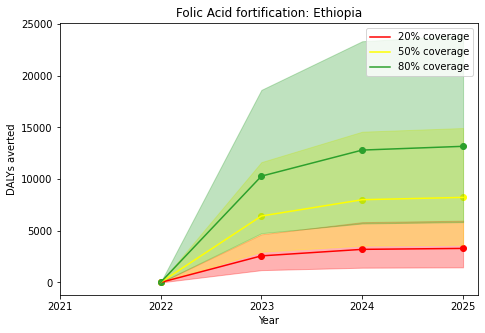

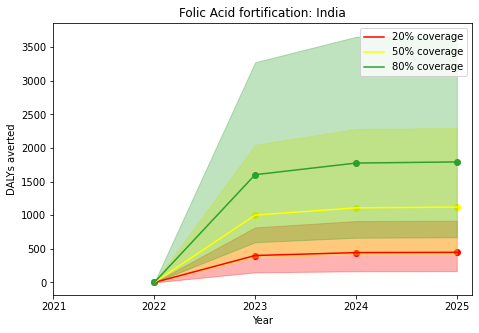

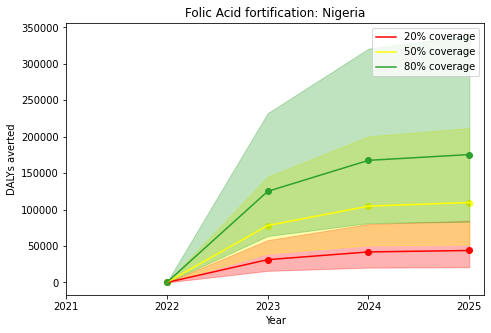

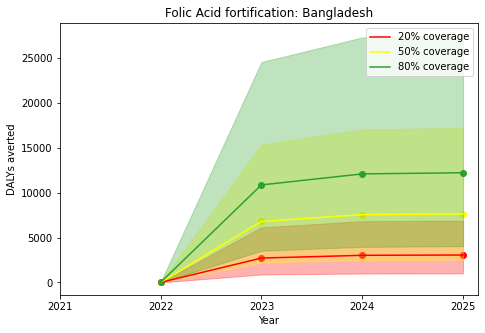

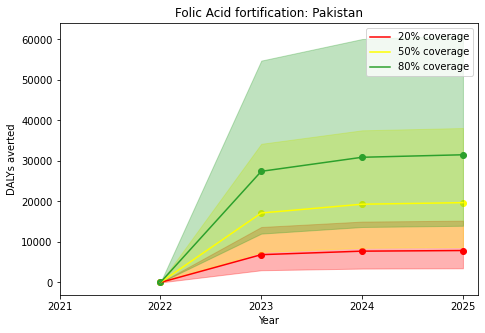

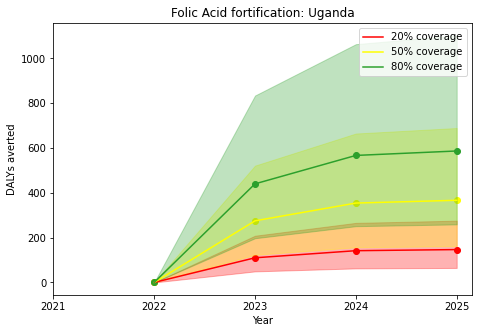

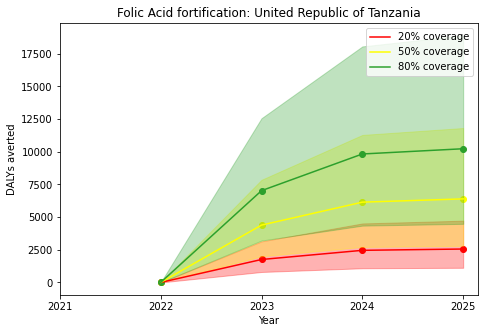

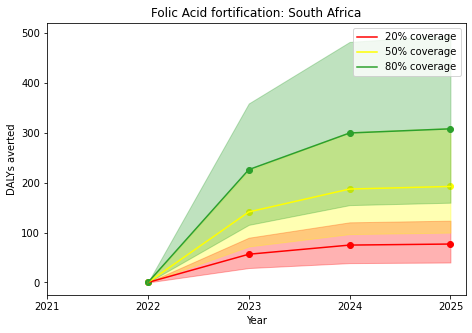

In [31]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


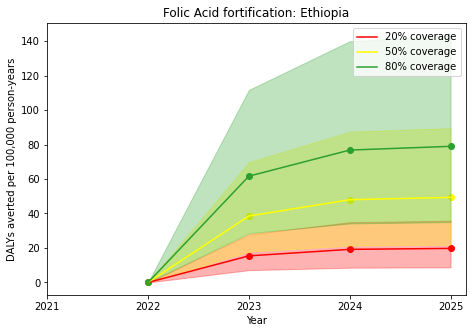

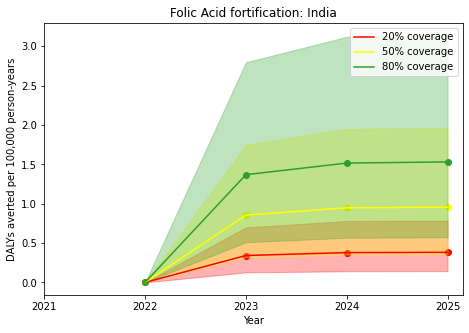

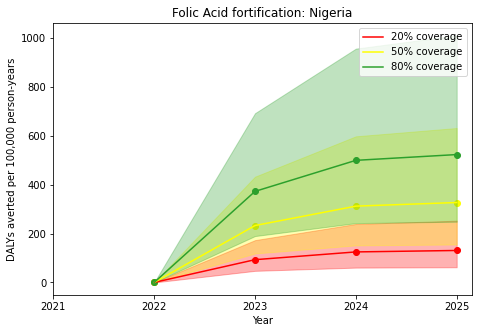

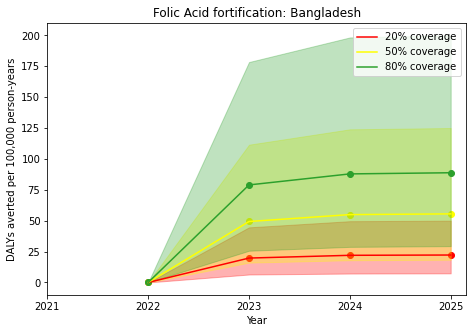

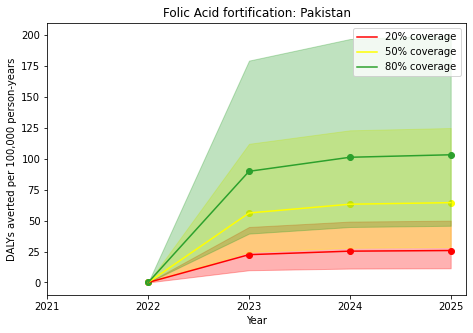

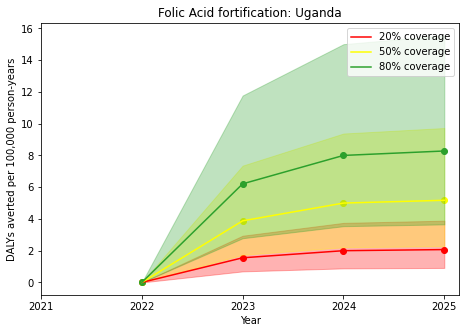

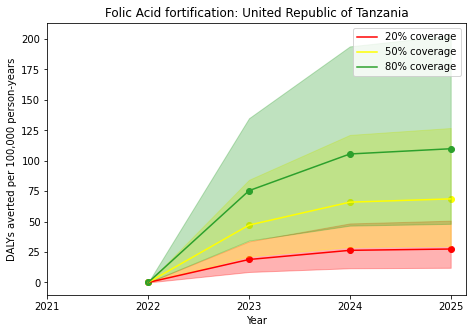

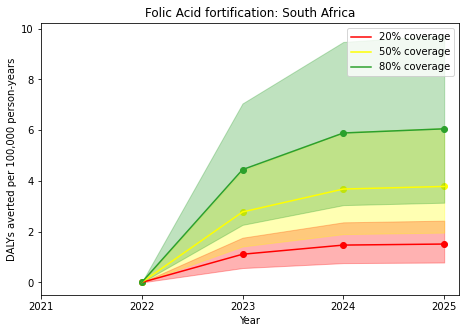

In [32]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


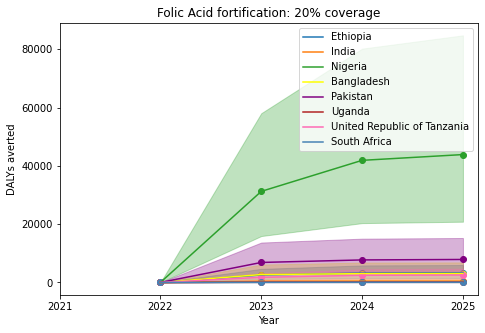

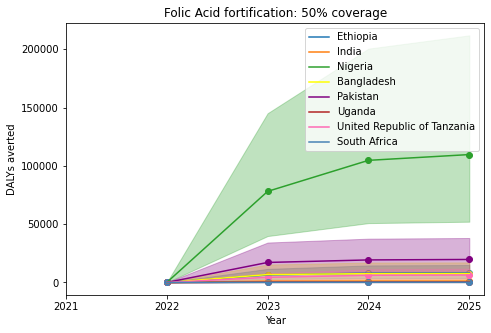

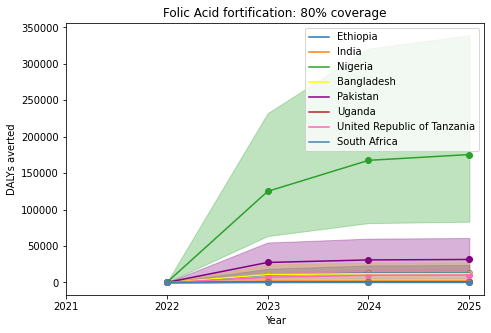

In [33]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick','hotpink','steelblue']

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for i in range(len(location_ids)):
            loc = location_ids[i]
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


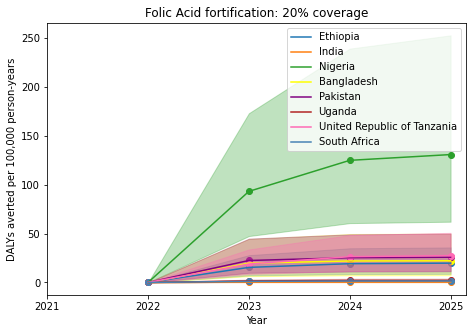

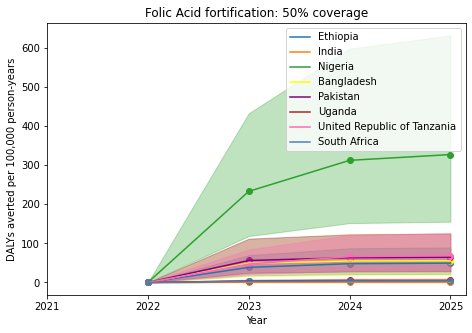

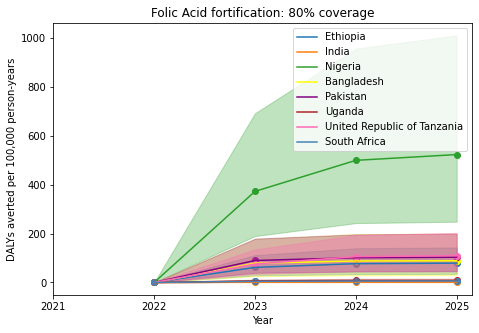

In [34]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick','hotpink','steelblue']

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for i in range(len(location_ids)):
            loc = location_ids[i]

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)